In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt

L:
[[1 0]
 [1 2]]
A = LL^T:
[[1 1]
 [1 5]]
M:
[[1 0]
 [2 1]]
B = MM^T:
[[1 2]
 [2 5]]


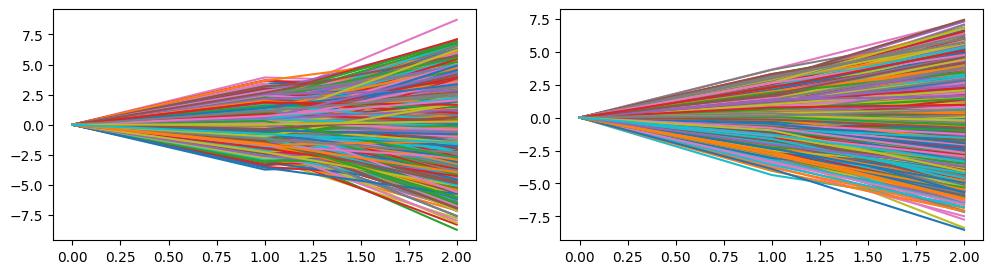

In [2]:
# Initialize samples
dim = 2
n_sample = 10000
normalize = False

L0 = np.array([[1, 0], [1, 2]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T
# np.linalg.cholesky(A) -  L

M0 = np.array([[1, 0], [2, 1]])
B0 = M0 @ M0.T  # A = LL^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T

# np.linalg.cholesky(B) -  M

print('L:')
print(L)
print('A = LL^T:')
print(A)

print('M:')
print(M)
print('B = MM^T:')
print(B)

noise1 = np.random.normal(size=[dim, n_sample])  # (dim, n_sample)
noise2 = np.random.normal(size=[dim, n_sample])  # (dim, n_sample)
X = L @ noise1  # (dim, n_sample)
Y = M @ noise2  # (dim, n_sample)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X)
ax[1].plot(Y)
plt.show()

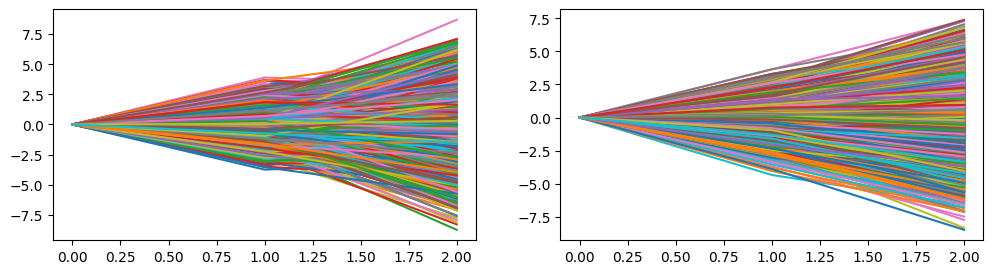

In [3]:
# Grid projection of k-mean projection

def adapted_empirical_measure(samples, delta_n):
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples

adaptedX = adapted_empirical_measure(X, delta_n = 0.05)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.05)

fig, ax = plt.subplots(1,2, figsize=[12,3])
ax[0].plot(adaptedX)
ax[1].plot(adaptedY)
plt.show()

In [4]:
# Quantization 
# Here I use the biggest one which works for both X and Y samples grid for simplicity.
q2v_list = np.unique(np.concatenate([adaptedX,adaptedY],axis = 0)) 
v2q_dict = {k: v for v, k in enumerate(q2v_list)}
# q2v_list, v2q_dict
len(q2v_list)

295

In [5]:
from collections import defaultdict
T = 3
def path2cm(adaptedpath):
    r'''
    Path to Conditional Measure
    '''
    mu_x = [defaultdict(dict) for t in range(T-1)]
    for path in adaptedpath.T:
        for t in range(T-1):
            pre_path = tuple(v2q_dict[v] for v in path[:t+1])
            next_val = v2q_dict[path[t+1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x
mu_x = path2cm(adaptedX)
nu_y = path2cm(adaptedY)

In [6]:
# Step t = 2
import ot
square_cost_matrix = (q2v_list[None,:] - q2v_list[None,:].T)**2
V1 = {}
for k1,v1 in mu_x[1].items():
    for k2,v2 in nu_y[1].items():
        w1 = list(v1.values())
        w1 = np.array(w1)/sum(w1)

        w2 = list(v2.values())
        w2 = np.array(w2)/sum(w2)
        
        square_cost = square_cost_matrix[np.ix_(list(v1.keys()),list(v2.keys()))]
        dist_W2square = ot.emd2(w1, w2, square_cost)
        
        V1[(k1,k2)] = dist_W2square

In [7]:
# Step t = 1
V0 = {}
for k1,v1 in mu_x[0].items():
    for k2,v2 in nu_y[0].items():
        w1 = list(v1.values())
        w1 = np.array(w1)/sum(w1)

        w2 = list(v2.values())
        w2 = np.array(w2)/sum(w2)

        q1s = list(v1.keys())
        q2s = list(v2.keys())

        square_cost = square_cost_matrix[np.ix_(q1s,q2s)]
        for i, q1 in enumerate(q1s):
            for j, q2 in enumerate(q2s):
                q_pair = (k1+(q1,),k2+(q2,))
                square_cost[i,j] += V1[q_pair]

        dist_W2square = ot.emd2(w1, w2, square_cost)
        V0[(k1,k2)] = dist_W2square
AW_2square = list(V0.values())[0]

In [8]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag

a, b  = np.zeros([3]), np.zeros([3])
dist_bench = adapted_wasserstein_squared(a,A,b,B)
print('Theoretical AW_2^2: ', dist_bench)
print('Numerical AW_2^2: ', AW_2square)

Theoretical AW_2^2:  2.0
Numerical AW_2^2:  2.0490417729098693
